In [40]:
import mne
import os
import os.path as osp

import pandas as pd
from mne.decoding import CSP
from sklearn.pipeline import make_pipeline
from pyriemann.spatialfilters import Xdawn
import numpy as np
from pyriemann.classification import MDM
from pyriemann.tangentspace import TangentSpace
from pyriemann.estimation import XdawnCovariances
from pyriemann.estimation import Covariances

import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

#
# from Independant_LDA import Independant_LDA
# from Independant_LDA import LDA as handmade_LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm


from numpy.random import seed

import winsound
import time



def beep():

    winsound.Beep(440, 500)
    winsound.Beep(330, 400)
    winsound.Beep(550, 500)

    return None


In [41]:

mne.set_log_level(verbose="Warning")  # set all the mne verbose to warning
seed(2002012)

init_path = "C:\\Users\dtrocell\Documents\ML\Big dataset\signal"
files_dir = os.listdir(init_path)[1:4]
participant_dir = [os.listdir(osp.join(init_path, files_dir[i])) for i in range(len(files_dir))]
print("you have succesfuly acces to the directory : ", init_path)
participant_dir[0].remove('A40')  # He dont have 40 events
participant_dir[0].remove('A59')  # He dont have 40 events


def collect_data(files_dir, participant_dir):
    dic_data_train = {}
    dic_data_test = {}
    for i in range(len(files_dir)):
        for j in range(len(participant_dir[i])):
            #Train dataset
            dic_data_train[participant_dir[i][j] + "_1"] = mne.io.read_raw_gdf(
                osp.join(init_path, files_dir[i], participant_dir[i][j], participant_dir[i][j] + "_R1_acquisition.gdf"),
                verbose="CRITICAL")
            dic_data_train[participant_dir[i][j] + "_2"] = mne.io.read_raw_gdf(
                osp.join(init_path, files_dir[i], participant_dir[i][j], participant_dir[i][j] + "_R2_acquisition.gdf"),
                verbose="CRITICAL")

            #Test dataset
            dic_data_test[participant_dir[i][j] + "_3"] = mne.io.read_raw_gdf(
                osp.join(init_path, files_dir[i], participant_dir[i][j], participant_dir[i][j] + "_R3_onlineT.gdf"),
                verbose="CRITICAL")
            dic_data_test[participant_dir[i][j] + "_4"] = mne.io.read_raw_gdf(
                osp.join(init_path, files_dir[i], participant_dir[i][j], participant_dir[i][j] + "_R4_onlineT.gdf"),
                verbose="CRITICAL")
            try:  # allow to manage the one where there is no _5 and _6 files
                dic_data_test[participant_dir[i][j] + "_5"] = mne.io.read_raw_gdf(
                    osp.join(init_path, files_dir[i], participant_dir[i][j], participant_dir[i][j] + "_R5_onlineT.gdf"),
                    verbose="CRITICAL")
            except FileNotFoundError:
                pass

            try:
                dic_data_test[participant_dir[i][j] + "_6"] = mne.io.read_raw_gdf(
                    osp.join(init_path, files_dir[i], participant_dir[i][j], participant_dir[i][j] + "_R6_onlineT.gdf"),
                    verbose="CRITICAL")
            except FileNotFoundError:
                pass
    return dic_data_train, dic_data_test


print("START extraction data")
dic_data_train, dic_data_test = collect_data(files_dir, participant_dir)
print("extraction data DONE")
participant_dir = [participant for session in participant_dir for participant in
                   session]  # flatten the list of the 3 participant session list in one big list

you have succesfuly acces to the directory :  C:\Users\dtrocell\Documents\ML\Big dataset\signal
START extraction data
extraction data DONE


In [42]:
def preprocess(raw, steps = {}):
    """ preprocess the data"""
    assert isinstance(steps, dict), "les steps doivent être un dictionnaire d'étapes"
    raw.load_data()
    if "drop_channels" in steps.keys():
        #remove the wanted channels
        for channel in steps["drop_channels"] : #Pour chaque channel  a supprimer
            if channel in raw.ch_names: raw.drop_channels(channel) # Vérifie qu'il est present et le supprime

    if "filter" in steps.keys():
        assert isinstance(steps["filter"], list), "les paramètres de 'filter' doivent une liste suivant cette forme [l_freq,h_freq]"
        raw.filter(steps["filter"][0], steps["filter"][1])


    return raw

In [43]:
 %matplotlib inline

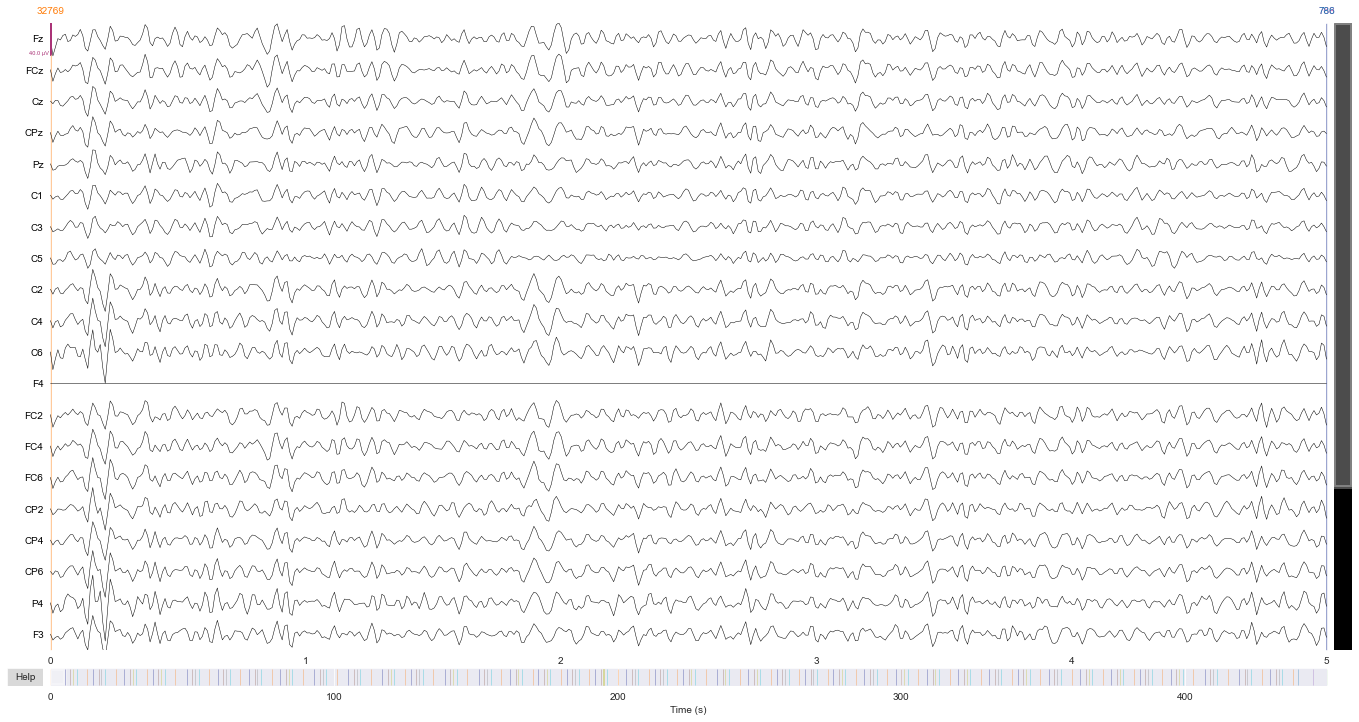

In [44]:
steps_preprocess = {"filter" : [8,30],
                    "drop_channels" : ['EOG1', 'EOG2', 'EOG3', 'EMGg', 'EMGd',] ,
                    "tmin" : 0.5 , "tmax" : 3.5, "overlap" :1, "lenght": 3,
                    "score" : "EAcc"}
_ = preprocess(dic_data_test["A42_5"], steps_preprocess)
_ = dic_data_test["A42_5"].plot(duration=5)

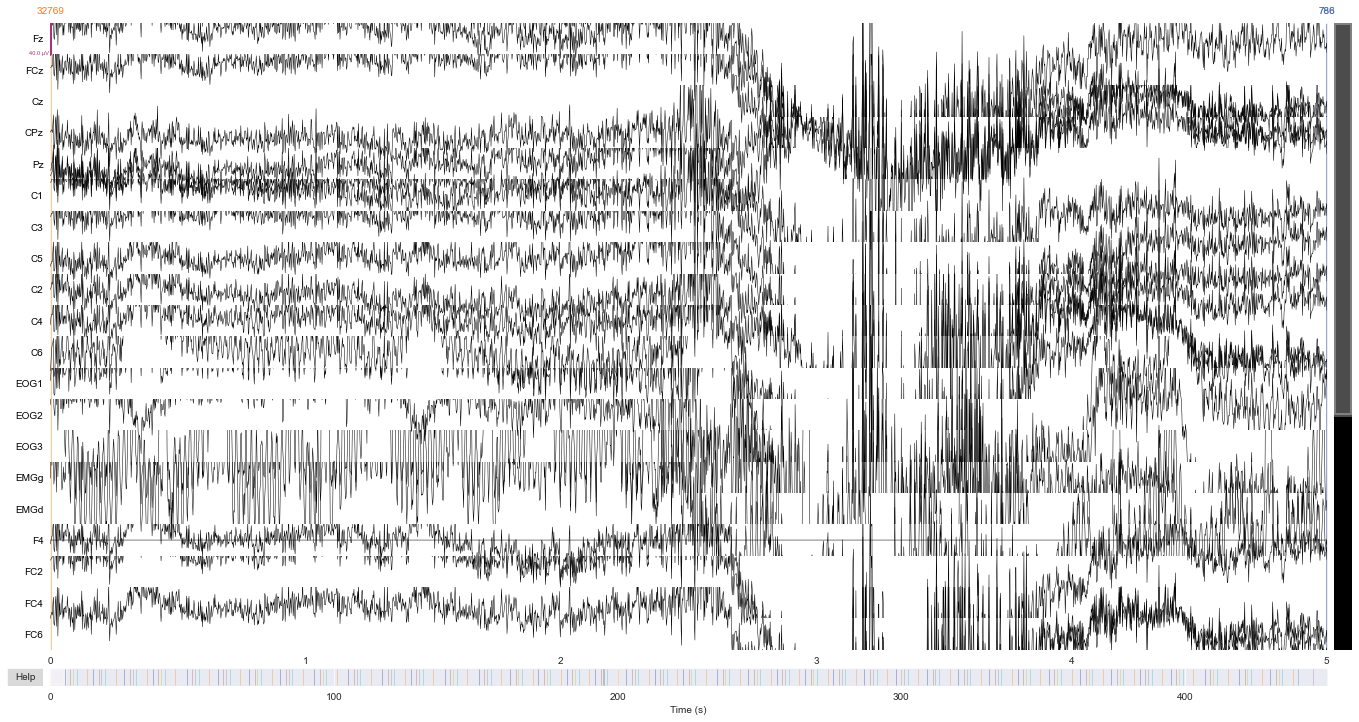

In [45]:
_ = preprocess(dic_data_test["A42_6"])
_ = dic_data_test["A42_6"].plot(duration=5)

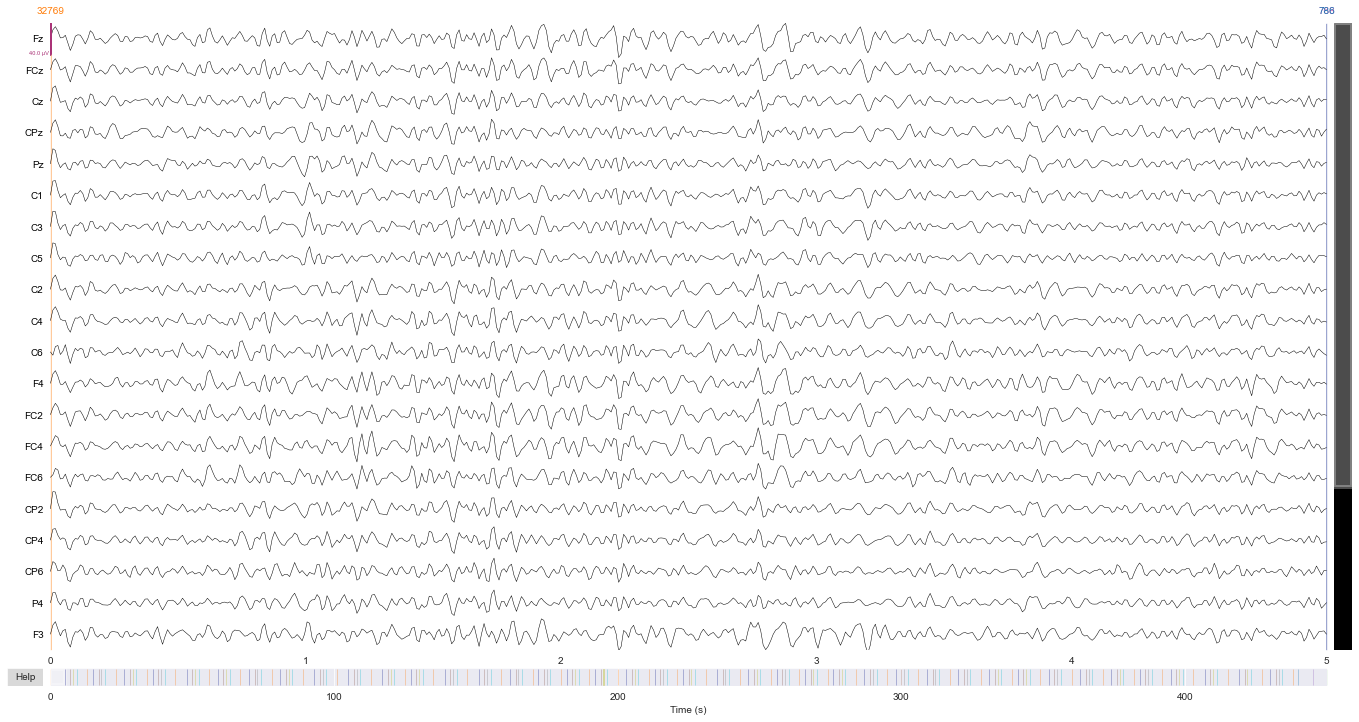

In [46]:

_ = preprocess(dic_data_train["A42_1"], steps_preprocess)
_ = dic_data_train["A42_1"].plot(duration=5)

In [47]:
for key in dic_data_train.keys():
    test = dic_data_train[key].get_data()
    if  ((test.mean(axis=1) == 0).any()).any() :
        print (key)
        print(np.where(test.mean(axis=1) == 0)[0])
        print(dic_data_train[key].ch_names[np.where(test.mean(axis=1) == 0)[0][0]])
        print("---------------------------------")
# for key in dic_data_test.keys():
#     dic_covariate_test[key]= extract_artefact(dic_data_test[key], "PFMA" , steps_epoching)
beep()

In [48]:
for key in dic_data_test.keys():
    test = dic_data_test[key].get_data()
    if  ((test.mean(axis=1) == 0).any()).any() :
        print (key)
        print(np.where(test.mean(axis=1) == 0)[0])
        print(dic_data_test[key].ch_names[np.where(test.mean(axis=1) == 0)[0][0]])
        print("---------------------------------")

beep()

A42_3
[16]
F4
---------------------------------
A42_4
[16]
F4
---------------------------------
A42_5
[11]
F4
---------------------------------
A42_6
[16]
F4
---------------------------------
A43_3
[16]
F4
---------------------------------
A43_4
[16]
F4
---------------------------------
A43_5
[16]
F4
---------------------------------
A43_6
[16]
F4
---------------------------------
A44_3
[16]
F4
---------------------------------
A44_4
[16]
F4
---------------------------------
A44_5
[16]
F4
---------------------------------
A44_6
[16]
F4
---------------------------------
A45_3
[16]
F4
---------------------------------
A45_4
[16]
F4
---------------------------------
A45_5
[16]
F4
---------------------------------
A45_6
[16]
F4
---------------------------------
A46_3
[16]
F4
---------------------------------
A46_4
[16]
F4
---------------------------------
A46_5
[16]
F4
---------------------------------
A46_6
[16]
F4
---------------------------------
A47_3
[16]
F4
--------------------------

 ['A30', 'A34', 'B70','B81'] C'est 4 sont les cas où j'ai eu une perf = 0.5 alors que F4 !=0

[ 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49',
 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A60',
  'C83', 'C85'] Ceci est la liste des signaux où F4 ==0

In [73]:
old_raw_42 =mne.io.read_raw_gdf("C:\\Users\dtrocell\Documents\ML\Big dataset\signal\Old version\XP2018_S41r3_onlineT.gdf")

In [89]:
_=old_raw_42.plot(duration=5)

In [90]:
_=dic_data_test["A42_3"].plot(duration=5)

In [93]:
old_raw_42.get_data(["Channel 17"]) == dic_data_test["A42_3"].get_data(["F4"])

array([[False, False, False, ...,  True,  True,  True]])

In [119]:
dic_data_test["A42_3"].get_data(["F4"])

array([[0., 0., 0., ..., 0., 0., 0.]])

In [117]:
old_raw_42.get_data(["CH_Event0"])

array([[0., 0., 0., ..., 0., 0., 0.]])

In [96]:
old_raw_42.get_data(["Channel 18"]) == dic_data_test["A42_3"].get_data(["FC2"])

array([[False, False, False, ...,  True,  True,  True]])

In [99]:
for channel in old_raw_42.ch_names :
    if (old_raw_42.get_data([channel]) == dic_data_test["A42_3"].get_data(["FC2"])).any():
        print (channel)

beep()

In [104]:
old_raw_42.get_data(["Channel 17"])

array([[-0.00316932, -0.00318974, -0.00322624, ...,  0.        ,
         0.        ,  0.        ]])

In [102]:
dic_data_test["A42_3"].get_data(["FC2"])

array([[-0.00316932, -0.00318974, -0.00322624, ...,  0.        ,
         0.        ,  0.        ]])

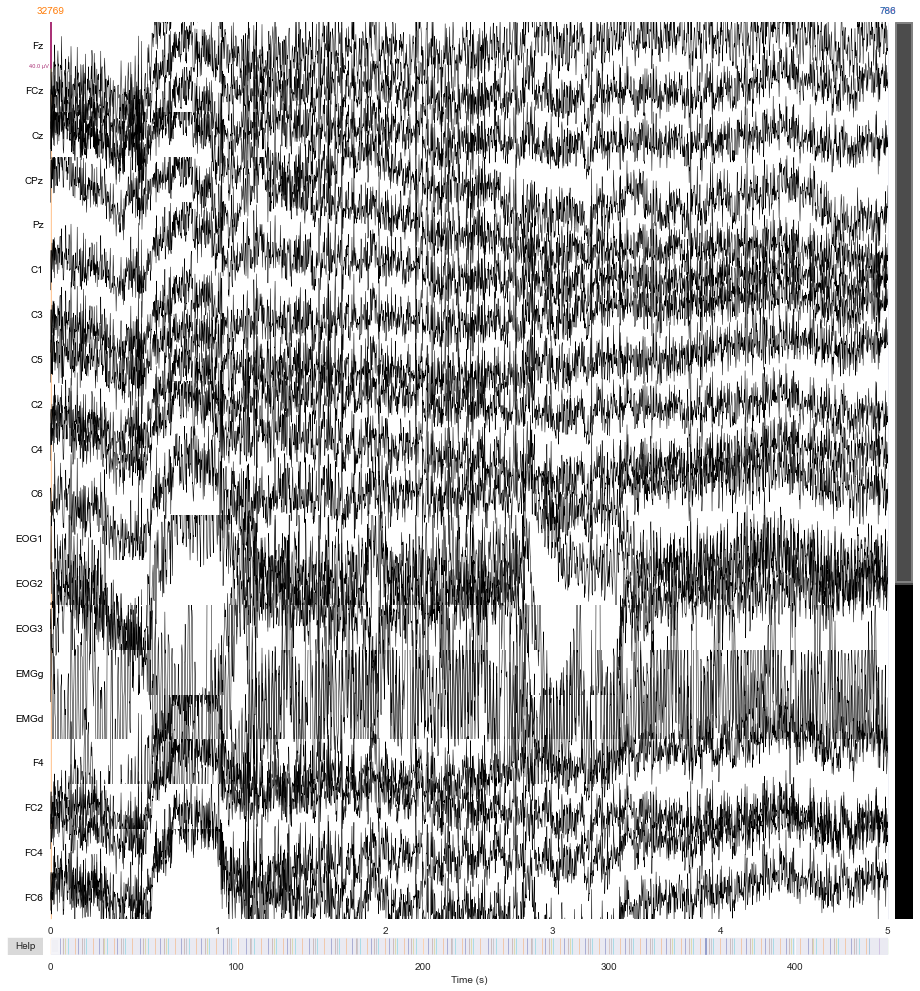

In [75]:
old_raw_42_s1 = mne.io.read_raw_gdf(
    "C:\\Users\dtrocell\Documents\ML\Big dataset\signal\Old version\XP2018_S41r1_acquisition.gdf")
_ = old_raw_42_s1.plot(duration=5)

In [106]:
old_raw_42_s1.get_data(["FC2"])


array([[-2.44466431e-05, -7.72097372e-07,  6.84646609e-06, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [107]:
dic_data_train["A42_1"].get_data(["FC2"])

array([[-1.90582413e-21,  1.76608538e-06,  3.53207922e-06, ...,
        -8.81345643e-07, -4.37202671e-07, -2.54109884e-21]])

In [109]:
old_raw_23_S3 = mne.io.read_raw_gdf('C:\\Users\\dtrocell\Documents\ML\Big dataset\signal\Old version\XP2018_S29r3_onlineT-[2018.05.11-14.08.24].gdf')

In [110]:
_ =old_raw_23_S3.plot(duration=5)

In [87]:
_=dic_data_test["A23_3"].plot(duration=5)

In [113]:
old_raw_23_S3.get_data(["Channel 17"])

array([[1.61676373e-02, 1.61722183e-02, 1.61704391e-02, ...,
        1.81898940e-18, 1.81898940e-18, 1.81898940e-18]])

In [114]:
dic_data_test["A23_3"].get_data(["F4"])

array([[0.01616764, 0.01617222, 0.01617044, ..., 0.        , 0.        ,
        0.        ]])

In [115]:
old_raw_23_S3.get_data(["Channel 18"])


array([[0.01903685, 0.01904236, 0.01904277, ..., 0.        , 0.        ,
        0.        ]])

In [116]:
dic_data_test["A23_3"].get_data(["FC2"])

array([[0.01903685, 0.01904236, 0.01904277, ..., 0.        , 0.        ,
        0.        ]])

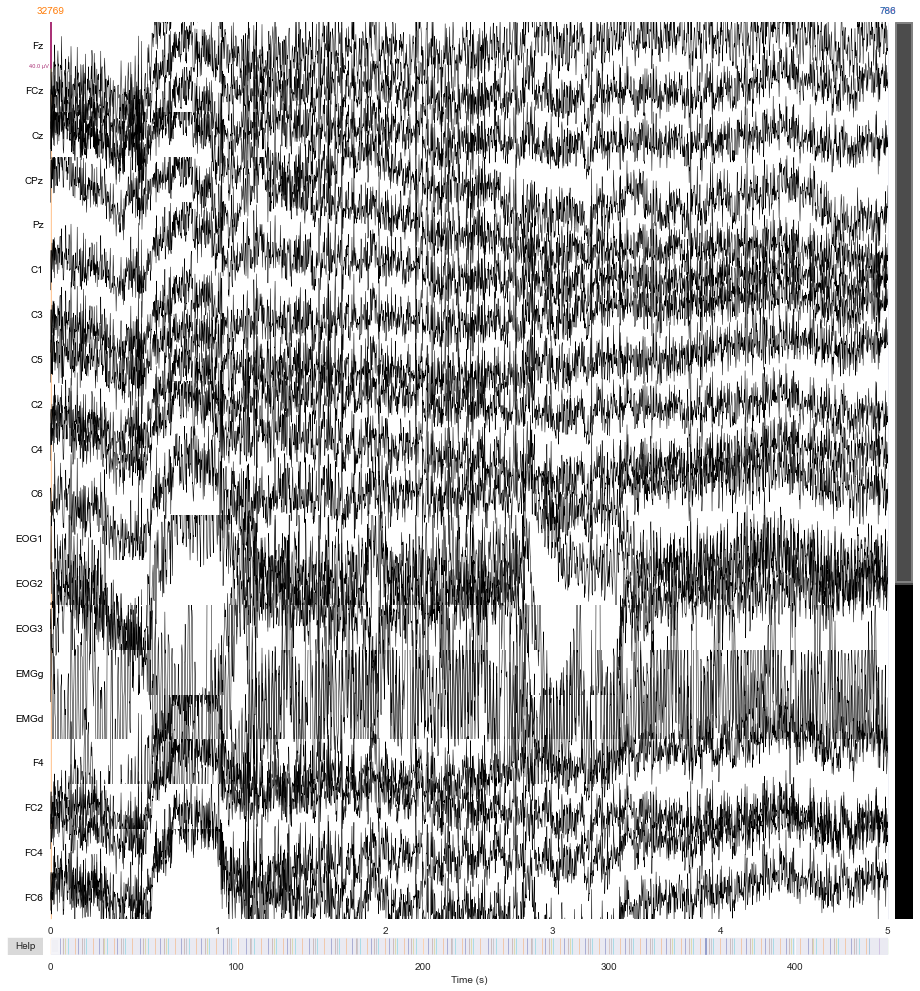

In [72]:

old_raw_40_S1 = mne.io.read_raw_gdf(
    'C:\\Users\dtrocell\Documents\ML\Big dataset\signal\Old version\XP2018_S41r1_acquisition.gdf')
_ = old_raw_40_S1.plot(duration=5)

In [86]:
%matplotlib qt